# Synthetic Rocks Simulation

## Inclusion properties

## In this example a mixture of three inclusion types are used:
## 20% of 0.01 aspect ratio
## 50% of 0.2 aspect rati0
## 30% of 0.70 aspect ratio




<ipython-input-3-b48073b14c65>:58: RuntimeWarning: invalid value encountered in log
  f[0] = np.log(alphai[0]/r[0]) + np.log(1.0 - phi0/phi) - np.log(1 - ((1.0 - phi)/(1.0 - phi0))**(1.0/n))
<ipython-input-3-b48073b14c65>:60: RuntimeWarning: invalid value encountered in log
  f[j] = f[j-1] + np.log(alphai[j]/r[j]) + np.log(r[j-1]/alphai[j-1] - fraci[j-1])


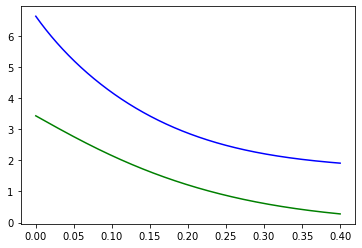

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 25 22:47:50 2021

@author: tamires
"""

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

def theta(alpha):
    return alpha*(np.arccos(alpha) - alpha*np.sqrt(1.0 - alpha*alpha))/(1.0 - alpha*alpha)**(3.0/2.0)

def f(alpha, theta):
    return alpha*alpha*(3.0*theta - 2.0)/(1.0 - alpha*alpha)

def PQ(A, B, R, theta, f):
    F1 = 1.0 + A*(1.5*(f + theta) - R*(1.5*f + 2.5*theta - 4.0/3.0))
    F2 = 1.0 + A*(1.0 + 1.5*(f + theta) - R*(1.5*f + 2.5*theta)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + theta - R*(f - theta + 2.0*theta*theta))
    F3 = 1.0 + A*(1.0 - f - 1.5*theta + R*(f + theta))
    F4 = 1.0 + (A/4.0)*(f + 3.0*theta - R*(f - theta))
    F5 = A*(-f + R*(f + theta - 4.0/3.0)) + B*theta*(3.0 - 4.0*R)
    F6 = 1.0 + A*(1.0 + f - R*(f + theta)) + B*(1.0 - theta)*(3.0 - 4.0*R)
    F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*theta - R*(3.0*f + 5.0*theta)) + B*theta*(3.0 - 4.0*R)
    F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (theta/2.0)*(5.0*R - 3.0)) + B*(1.0 - theta)*(3.0 - 4.0*R)
    F9 = A*((R - 1.0)*f - R*theta) + B*theta*(3.0 - 4.0*R)
    
    P = 3.0*F1/F2
    Q = 2.0/F3 + 1.0/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
    return P, Q

def KG(Km, Gm, Ki, Gi, ci, theta, f):
    A = Gi/Gm - 1.0
    B = (Ki/Km - Gi/Gm)/3.0
    R = Gm/(Km + (4.0/3.0)*Gm)
    Fm = (Gm/6.0)*(9.0*Km + 8.0*Gm)/(Km + 2.0*Gm)
    
    P, Q = PQ(A, B, R, theta, f)

    K = Km - (Km + (4.0/3.0)*Gm)*ci*(Km - Ki)*P/3.0/(Km + (4.0/3.0)*Gm + ci*(Km - Ki)*P/3.0)
    G = Gm - (Gm + Fm)*ci*(Gm - Gi)*Q/5.0/(Gm + Fm + ci*(Gm - Gi)*Q/5.0)
    
    return K, G

def DEM(Km, Gm, Ki, Gi, alphai, phii, phi0=0.0, r=1000, phitol=1.0E-10, gamma=0.01):
    phi = np.sum(phii)
    fraci = phii/np.sum(phi)
    ci = fraci*alphai/r
    n = int(np.ceil((np.log(1.0-phi)-np.log(1.0-phi0))/np.sum(np.log(1.0-ci))))
    m = len(alphai)
    
    def func(r):
        f = np.empty(m)
        f[0] = np.log(alphai[0]/r[0]) + np.log(1.0 - phi0/phi) - np.log(1 - ((1.0 - phi)/(1.0 - phi0))**(1.0/n))
        for j in range(1, m):
            f[j] = f[j-1] + np.log(alphai[j]/r[j]) + np.log(r[j-1]/alphai[j-1] - fraci[j-1])
        return f
    
    def fprime(r):
        jac = np.diag(-1.0/r)
        for j in range(0, m-1):
            jac[j+1:, j] = -1.0/r[j] + 1.0/(r[j] - fraci[j]*alphai[j])
        
        return jac
    
    r0 = r*np.ones(m)
    
    ri = fsolve(func, r0, fprime=fprime, factor=0.1)
    
    ci = fraci*alphai/ri
    
    thetai = theta(alphai)
    fi = f(alphai, thetai)
    
    K = np.empty(n)
    G = np.empty(n)
    phi = np.empty(n)

    K_ = Km
    G_ = Gm
    phi_ = phi0
    
    for i in range(n):
        dphi = ci[0]*(1.0 - phi_)
        K_, G_ = KG(K_, G_, Ki[0], Gi[0], ci[0], thetai[0], fi[0])
        phi_ += dphi
        for j in range(1, m):
            dphi *= ci[j]*(1.0 - ci[j-1])/ci[j-1]
            K_, G_ = KG(K_, G_, Ki[j], Gi[j], ci[j], thetai[j], fi[j])
            phi_ += dphi
        K[i] = K_
        G[i] = G_
        phi[i] = phi_
    
    return K, G, phi



#Gassman Equation
def Ks(Kd, Km, Kf, phi):
    gamma = 1.0 - phi - Kd/Km
    return Kd + (gamma + phi)**2/(gamma/Km + phi/Kf)


def Kd(Ks, Km, Kf, phi):
    gamma = phi*(Km/Kf - 1.0)
    return (Ks*(gamma + 1.0) - Km)/(gamma - 1.0 + Ks/Km)

# Matrix properties
Km = 77.0 # GPa
Gm = 32.0 # GPa
rhom = 2.71 # g/cm3

# Fluid properties
Kf = 3.0 # GPa
rhof = 1.0 # g/cm3

# Porosity
phimax = 0.4

alphas = np.array([0.01, 0.2, 0.7])
volumes = np.array([0.2, 0.5, 0.3])*phimax

# Dry inclusions
Kis = np.zeros(len(alphas), dtype=float)
Gis = np.zeros(len(alphas), dtype=float)


K, G, phi = DEM(Km, Gm, Kis, Gis, alphas, volumes)

rho = (1.0 - phi)*rhom + phi*rhof
Ks =Ks(K, Km, Kf, phi)

Vp = np.sqrt((Ks + 4.0*G/3.0)/rho)
Vs = np.sqrt(G/rho)

plt.plot(phi, Vp, 'b', label='Vp')
plt.plot(phi, Vs, 'g', label='Vs')



plt.show()